In [30]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
B = 5
G = 3

import pandas as pd
import matplotlib.pyplot as plt
import glob

In [31]:
plt.rcParams.update({
    "font.size": 14,            # Default text size
    "axes.titlesize": 18,       # Title size
    "axes.labelsize": 14,       # X and Y label size
    "xtick.labelsize": 12,      # X-axis tick size
    "ytick.labelsize": 12,      # Y-axis tick size
    "legend.fontsize": 14,      # Legend font size
    "figure.titlesize": 18,     # Figure title size
    "lines.linewidth": 2.5
})

In [33]:
column_mapping = {
        "solveMILP": "MILP",
        "solveConicGibbsGreedyDynamic": "Greedy Dynamic",
        # "PPO_4Bucket_20000000": "PPO 4",
        # "PPO_4Bucket_50000000": "PPO 4+",
        # "PPO_5Bucket_20000000" : "PPO 5",
        # "PPO_5Bucket_50000000": "PPO 5+"
    }

columns_to_plot = list(column_mapping.values())

# Define parameters
base_path = "data/types/"

# Load data
dfs = []
B_values = range(1, 6)
for B in B_values:
    file_path = f"{base_path}sample_N50_d2_B{B}_G{G}_Utils3.csv"
    df = pd.read_csv(file_path)
    df = df.rename(columns=column_mapping)
    df["B"] = B  # Track B value
    dfs.append(df)


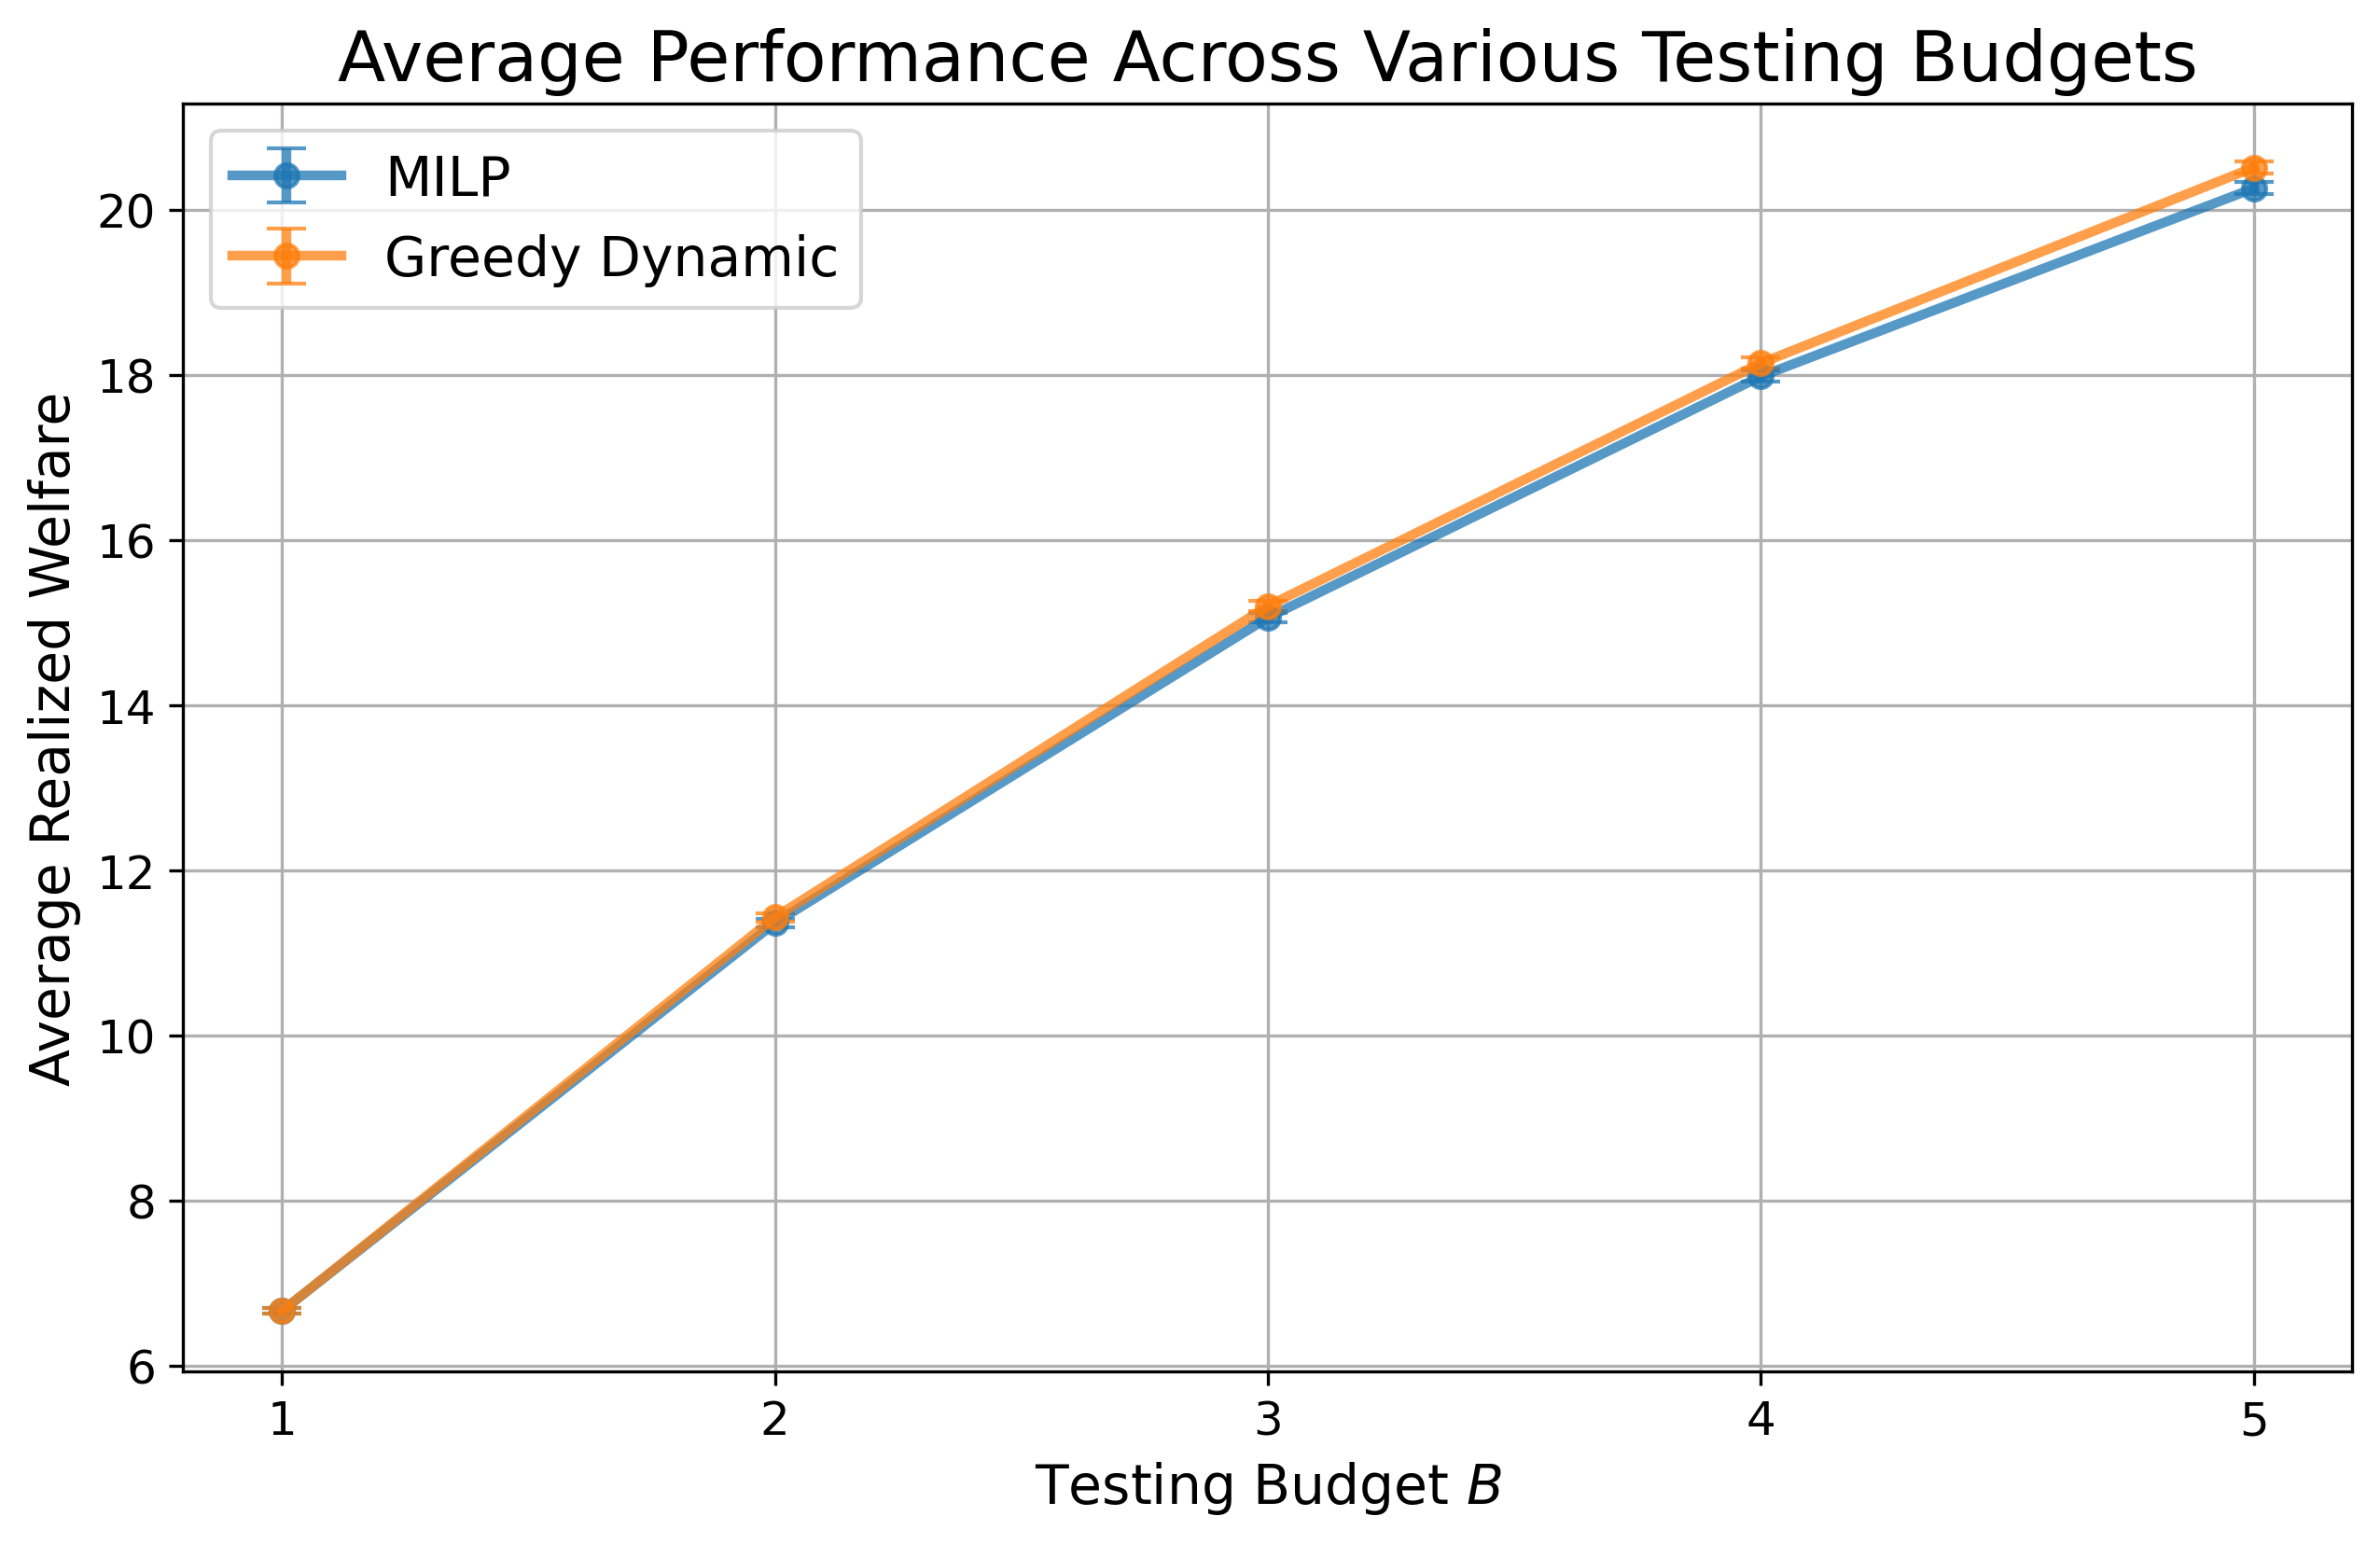

In [34]:
# Combine data
combined_df = pd.concat(dfs, ignore_index=True)

# Compute mean and standard error for each B
mean_df = combined_df.groupby("B")[columns_to_plot].mean()
std_err_df = combined_df.groupby("B")[columns_to_plot].sem()  # Standard error of the mean (SEM)

# Plot results with error bars
plt.figure(figsize=(10, 6))
for col in columns_to_plot:
    plt.errorbar(mean_df.index, mean_df[col], yerr=std_err_df[col], fmt='-o', alpha=0.75, label=col, capsize=5)

plt.xticks(B_values)
plt.xlabel("Testing Budget $B$")
plt.ylabel("Average Realized Welfare")
plt.title("Average Performance Across Various Testing Budgets")
plt.legend()
plt.grid()
plt.show()

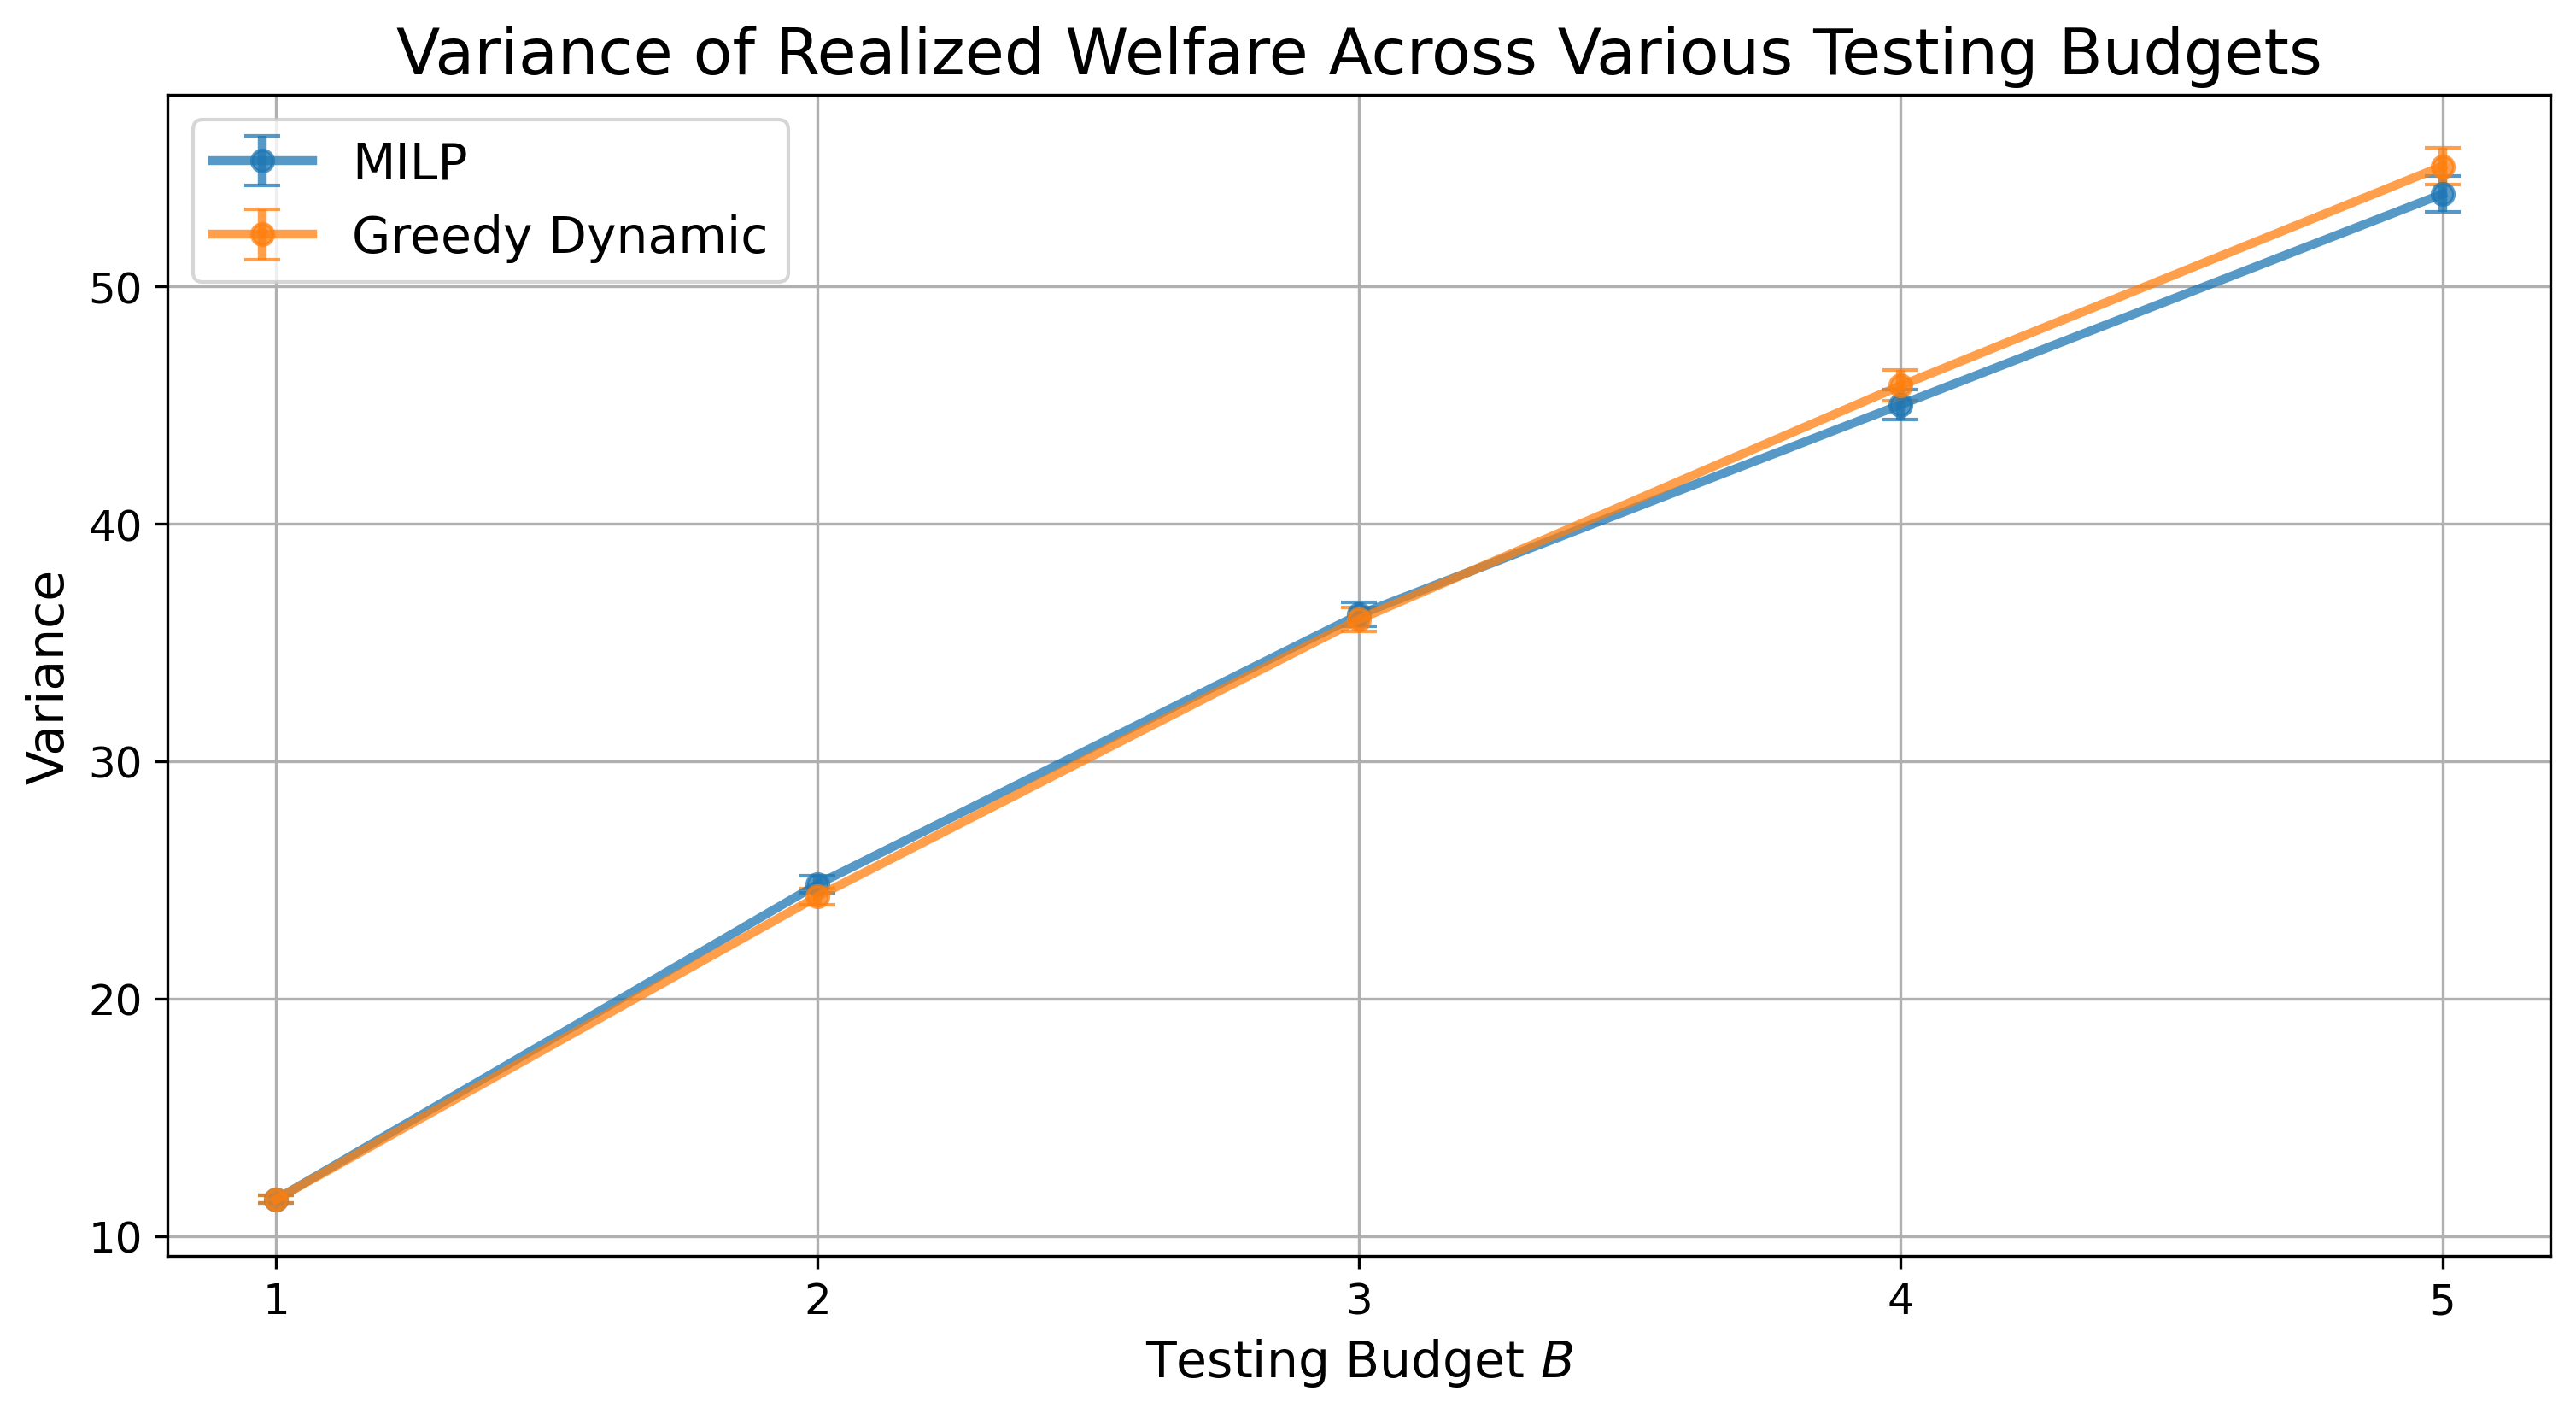

In [35]:
# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Compute sample variance for each B
variance_df = combined_df.groupby("B")[columns_to_plot].var()

# Count the number of samples for each B (needed for SE of variance)
count_df = combined_df.groupby("B")[columns_to_plot].count()

# Compute standard error of the sample variance (assuming normality)
se_of_variance_df = variance_df * np.sqrt(2.0 / (count_df - 1))

# Plot variance with error bars
plt.figure(figsize=(12, 6))
for col in columns_to_plot:
    plt.errorbar(
        x=variance_df.index,
        y=variance_df[col],
        yerr=se_of_variance_df[col],
        fmt='-o',
        alpha=0.75,
        label=col,
        capsize=5
    )
plt.xticks(variance_df.index) 
plt.xlabel("Testing Budget $B$")
plt.ylabel("Variance")
plt.title("Variance of Realized Welfare Across Various Testing Budgets")
plt.legend()
plt.grid(True)
plt.show()

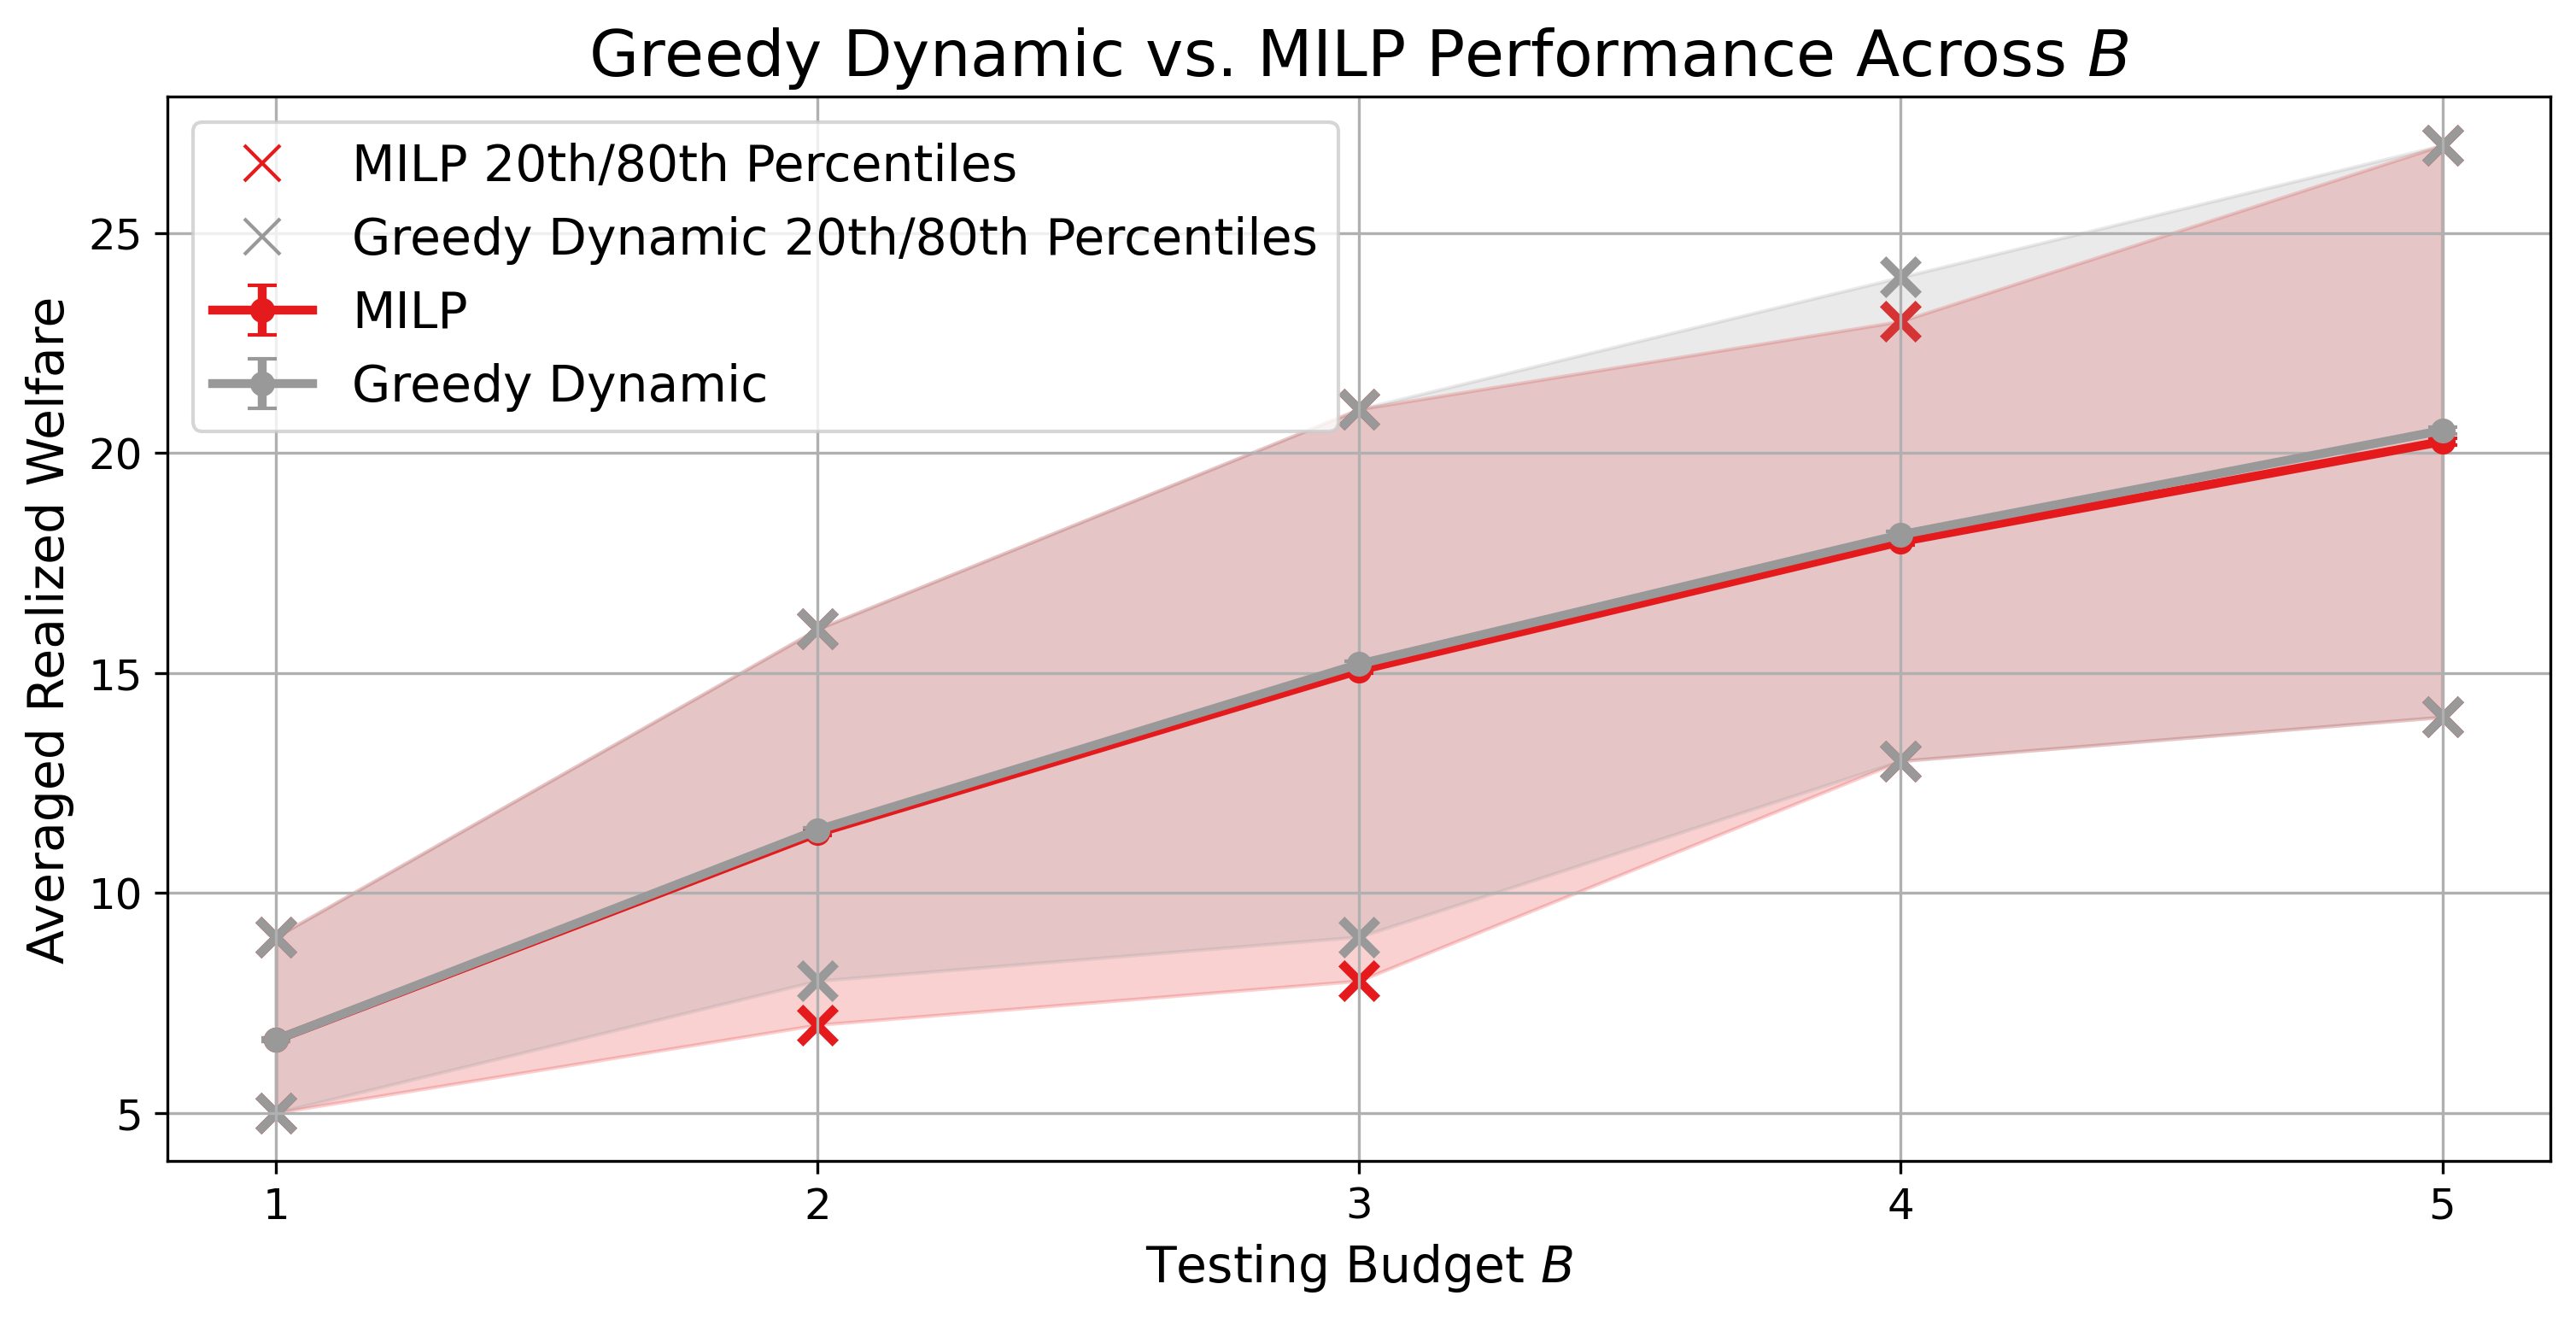

In [46]:
percentile_lower = 20  # Lower bound for cone
percentile_upper = 80  # Upper bound for cone

# Combine data
combined_df = pd.concat(dfs, ignore_index=True)

# Group by B and compute mean & percentiles
mean_df = combined_df.groupby("B")[columns_to_plot].mean()
percentile_lower_df = combined_df.groupby("B")[columns_to_plot].quantile(percentile_lower / 100)
percentile_upper_df = combined_df.groupby("B")[columns_to_plot].quantile(percentile_upper / 100)

# -- Compute Standard Error of the Mean (SEM) --
std_df = combined_df.groupby("B")[columns_to_plot].std()
count_df = combined_df.groupby("B")[columns_to_plot].count()
sem_df = std_df / np.sqrt(count_df)  # SEM = std / sqrt(n)

plt.figure(figsize=(12, 5.5))
colors = plt.cm.get_cmap("Set1", len(columns_to_plot))

for idx, col in enumerate(columns_to_plot):
    color = colors(idx)

    # Plot central mean line *with error bars* using the SEM
    plt.errorbar(
        mean_df.index,
        mean_df[col],
        yerr=sem_df[col],
        marker='o',
        linestyle='-',
        color=color,
        capsize=4,
        label=col
    )
    
    # Fill between percentiles to create the "cone"
    plt.fill_between(
        mean_df.index,
        percentile_lower_df[col],
        percentile_upper_df[col],
        color=color,
        alpha=0.2
    )

    # Plot "X" markers for the percentiles
    plt.scatter(
        percentile_lower_df.index,
        percentile_lower_df[col],
        marker='x',
        color=color,
        s=100
    )
    plt.scatter(
        percentile_upper_df.index,
        percentile_upper_df[col],
        marker='x',
        color=color,
        s=100
    )

    # Add a legend entry for the percentile markers
    plt.plot(
        [], [], marker='x', linestyle='', color=color,
        markersize=10, label=f"{col} {percentile_lower}th/{percentile_upper}th Percentiles"
    )

# Ensure x-axis only contains integer values (B values)
plt.xticks(B_values)

plt.xlabel("Testing Budget $B$")
plt.ylabel("Averaged Realized Welfare")
plt.title("Greedy Dynamic vs. MILP Performance Across $B$")
plt.legend()
plt.grid()
plt.show()


Paired Data: Mean Differences and Standard Errors:
B=1: Mean Diff = 0.0000, SE = 0.0000
B=2: Mean Diff = 0.0687, SE = 0.0141
B=3: Mean Diff = 0.1405, SE = 0.0238
B=4: Mean Diff = 0.1596, SE = 0.0305
B=5: Mean Diff = 0.2519, SE = 0.0364


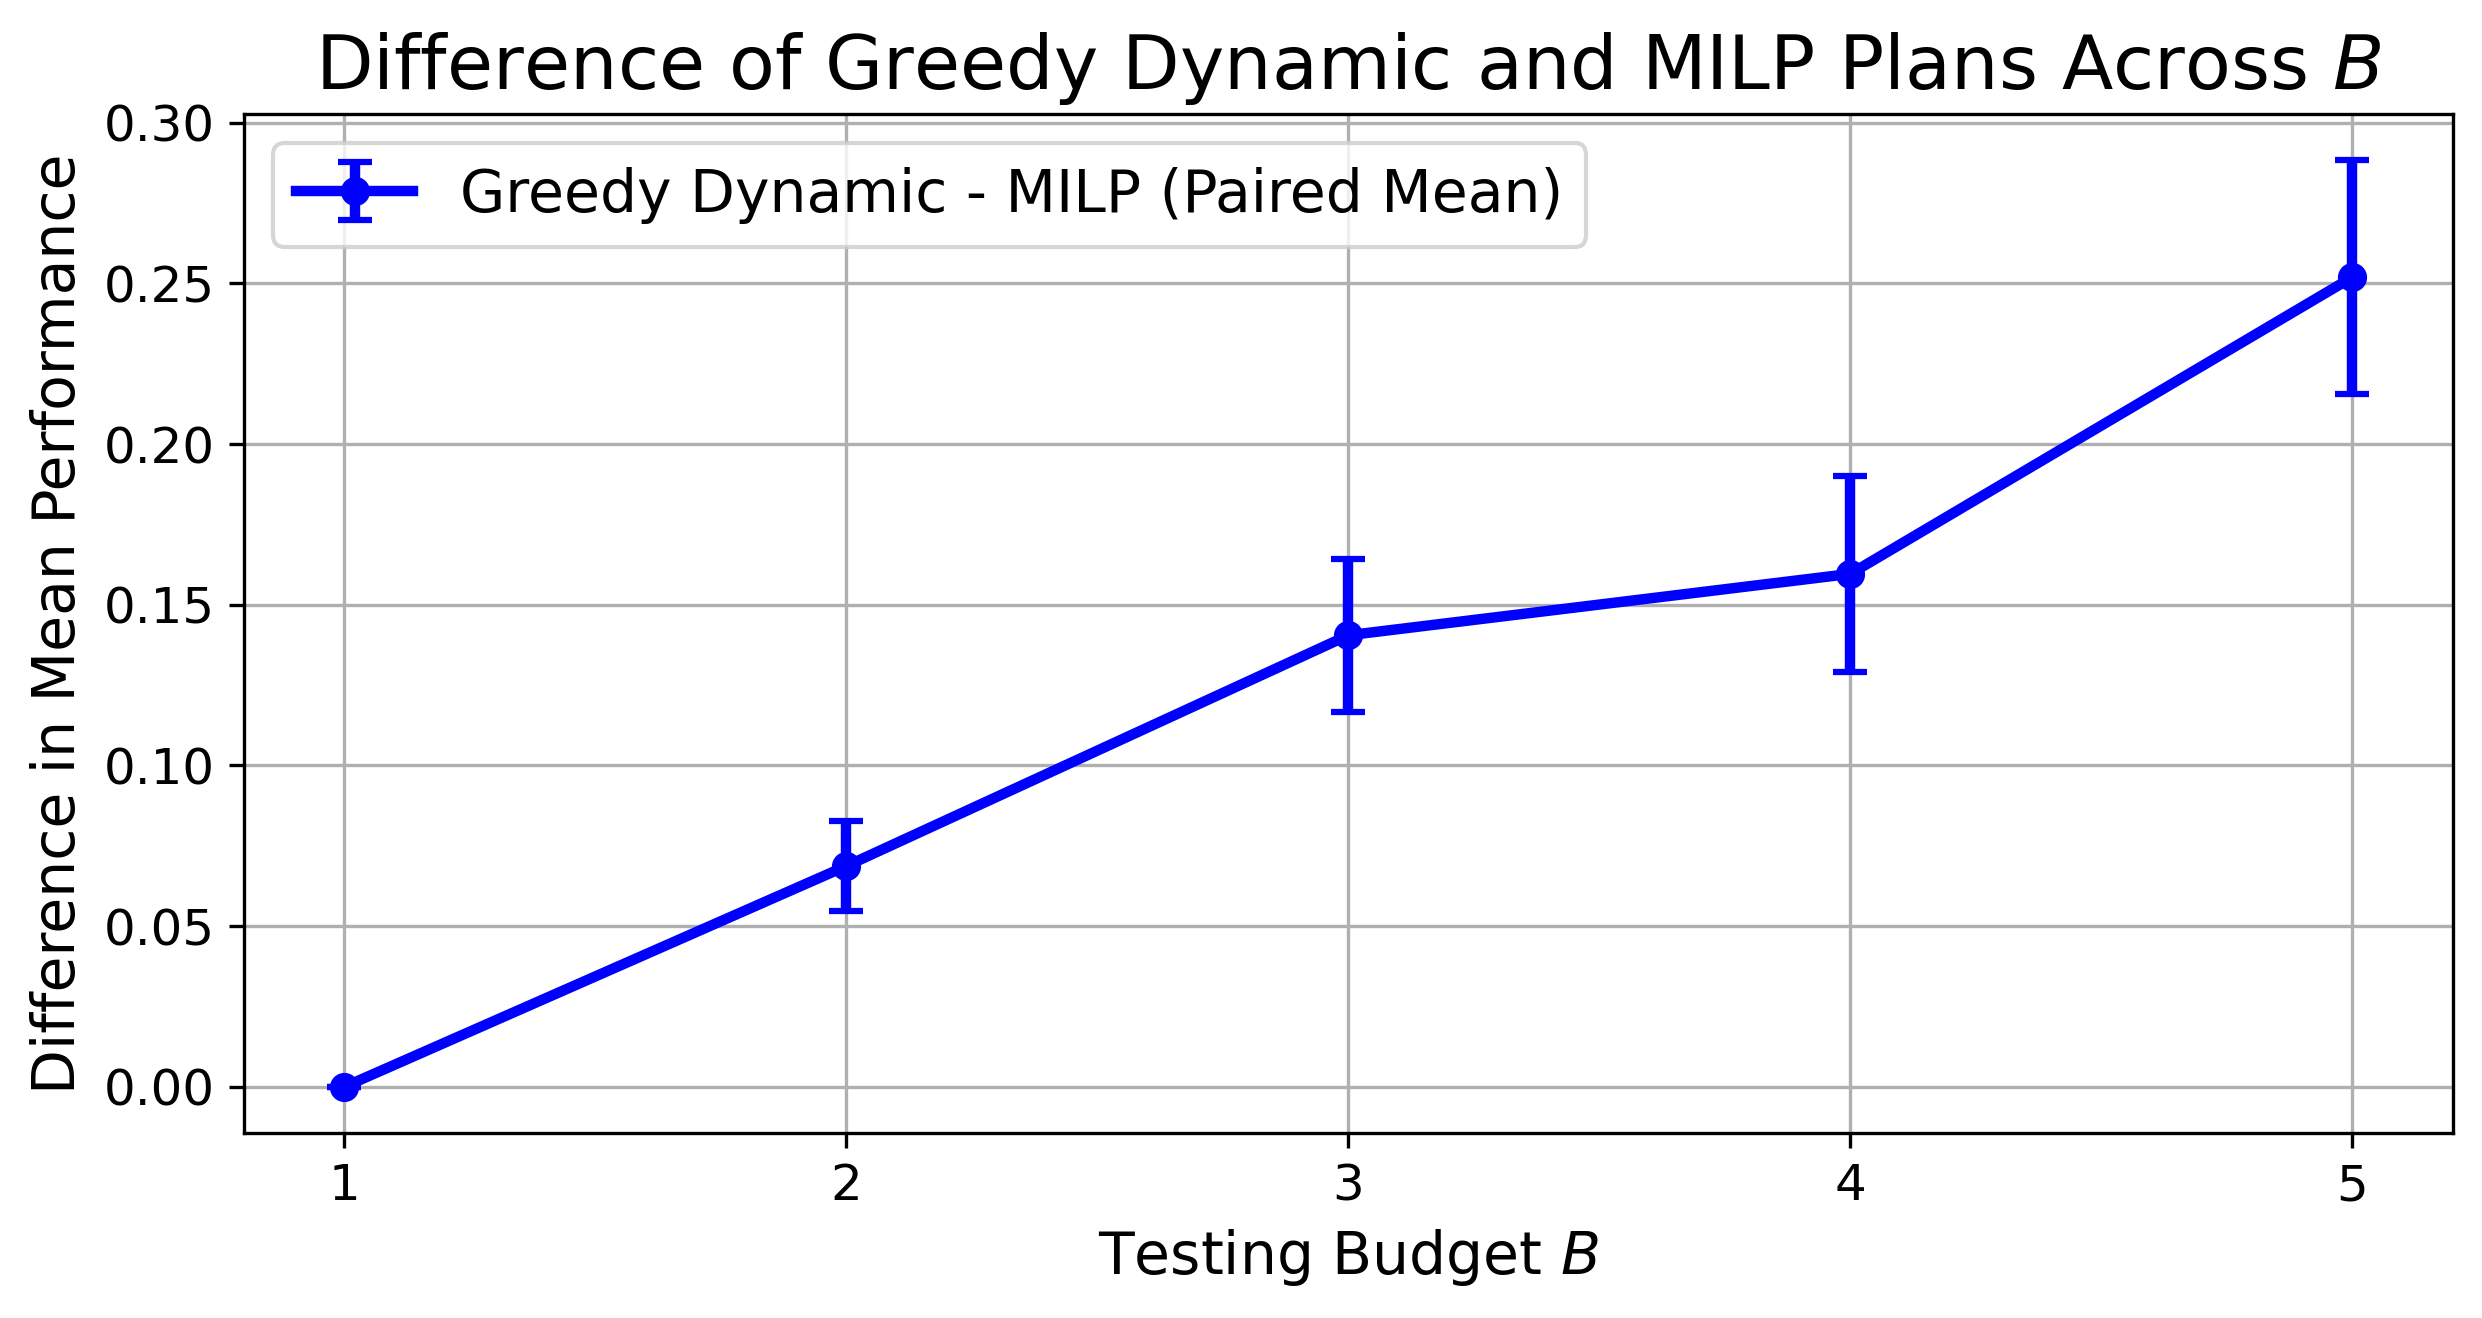

In [45]:
col1 = "Greedy Dynamic"  # Change as needed
col2 = "MILP"            # Change as needed

use_mean = True          # Set to True for mean difference calculations
percentiles = []         # Which percentiles to plot (only used if use_mean=False)
paired = True           # Set to True if col1 and col2 are paired (e.g., same seeds/units)

# ----------------------------------------------------------
# Combine data (adjust as needed)
combined_df = pd.concat(dfs, ignore_index=True)

# Initialize figure
plt.figure(figsize=(9.5, 4.5))
colors = plt.cm.get_cmap("tab10", len(percentiles))  # For percentile lines

# ----------------------------------------------------------
# CASE 1: Calculate MEAN differences (+ standard error)
# ----------------------------------------------------------
if use_mean:
    if paired:
        # 1) Compute difference for each row
        combined_df["diff"] = combined_df[col1] - combined_df[col2]

        # 2) Group by B and compute mean and standard error of these differences
        grouped = combined_df.groupby("B")["diff"]
        diff_mean = grouped.mean()
        # Standard error for paired differences:
        std_diff = grouped.std() / np.sqrt(grouped.count())

        # Print values
        print("Paired Data: Mean Differences and Standard Errors:")
        for b in diff_mean.index:
            print(f"B={b}: Mean Diff = {diff_mean[b]:.4f}, SE = {std_diff[b]:.4f}")

        # Plot
        plt.errorbar(
            diff_mean.index, diff_mean, yerr=std_diff, fmt='o-',
            color="blue", capsize=4, capthick=1.5,
            label=f"{col1} - {col2} (Paired Mean)"
        )

    else:
        # Treat col1 and col2 as independent samples
        mean_df = combined_df.groupby("B")[[col1, col2]].mean()
        std_df = combined_df.groupby("B")[[col1, col2]].std()
        count_df = combined_df.groupby("B")[[col1, col2]].count()

        diff_mean = mean_df[col1] - mean_df[col2]
        # Standard error for independent means
        std_diff = np.sqrt(
            (std_df[col1]**2) / count_df[col1] + 
            (std_df[col2]**2) / count_df[col2]
        )

        # Print values
        print("Independent Data: Mean Differences and Standard Errors:")
        for b in diff_mean.index:
            print(f"B={b}: Mean Diff = {diff_mean[b]:.4f}, SE = {std_diff[b]:.4f}")

        # Plot
        plt.errorbar(
            diff_mean.index, diff_mean, yerr=std_diff, fmt='o-',
            color="blue", capsize=4, capthick=1.5,
            label=f"{col1} - {col2} (Mean)"
        )

# ----------------------------------------------------------
# CASE 2: Calculate PERCENTILE differences
# (Only used if use_mean=False or you want to plot them in addition)
# ----------------------------------------------------------
if not use_mean:
    percentile_dfs = {
        p: combined_df.groupby("B")[[col1, col2]].quantile(p / 100) 
        for p in percentiles
    }
    diff_percentiles = {
        p: percentile_dfs[p][col1] - percentile_dfs[p][col2] 
        for p in percentiles
    }

    for idx, p in enumerate(percentiles):
        color = colors(idx)
        plt.plot(
            diff_percentiles[p].index,
            diff_percentiles[p],
            marker='o',
            linestyle='--',
            color=color,
            label=f"{p}th percentile"
        )
        # Print percentile values
        print(f"\n{p}th Percentile Differences:")
        for b in diff_percentiles[p].index:
            print(f"B={b}: {diff_percentiles[p][b]:.4f}")

# ----------------------------------------------------------
# Plot Formatting
# ----------------------------------------------------------
plt.xlabel("Testing Budget $B$")
if use_mean:
    plt.ylabel("Difference in Mean Performance")
    plt.title(f"Difference of {col1} and {col2} Plans Across $B$")
else:
    plt.ylabel("Difference in Performance (Percentiles)")
    plt.title(f"Percentile Differences of {col1} and {col2} Across $B$")

# If use_mean is True, we used diff_mean for x-ticks; 
# if use_mean is False, we might want to pick any group index:
if use_mean:
    plt.xticks(diff_mean.index)
else:
    # If you have at least one percentile, we can pick the first one to define the ticks
    if percentiles:
        example_p = percentiles[0]
        plt.xticks(diff_percentiles[example_p].index)

plt.legend()
plt.grid()
plt.show()

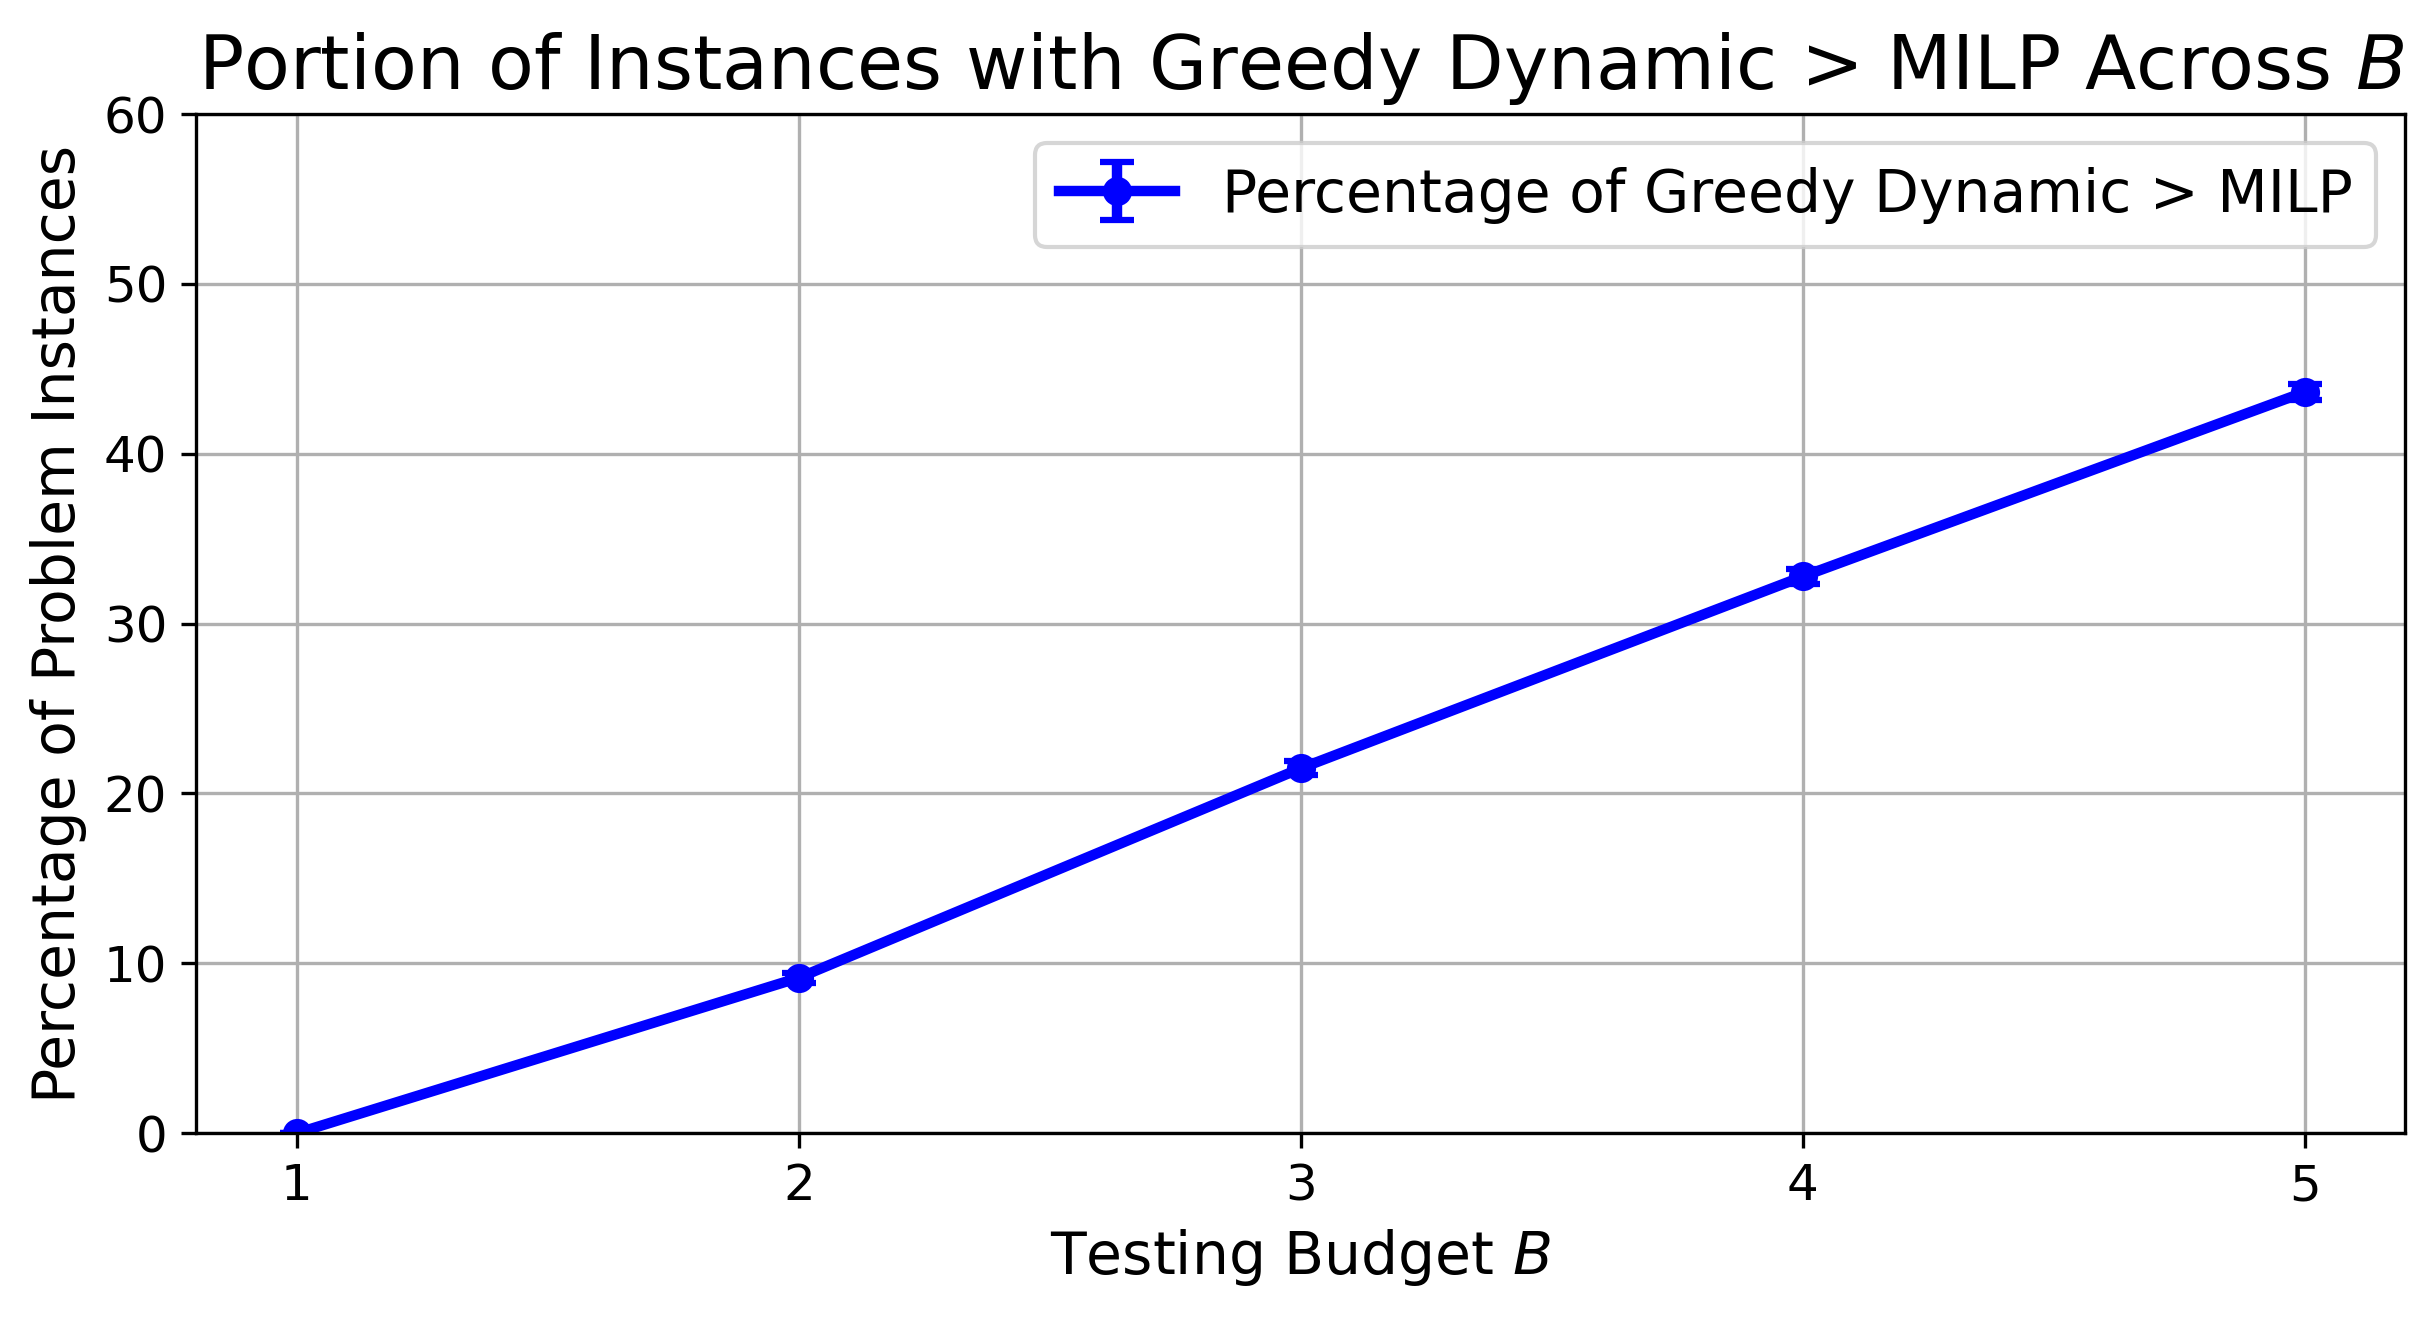

In [44]:
# Choose two algorithms to compare
col1 = "Greedy Dynamic"  # Change as needed
col2 = "MILP"            # Change as needed

# Combine data
combined_df = pd.concat(dfs, ignore_index=True)

# For each B, compute the proportion of times col1 > col2
prop_df = combined_df.groupby("B").apply(lambda x: (x[col1] > x[col2]).mean())
counts_df = combined_df.groupby("B").size()

# Convert proportion to percentage
percentage_df = prop_df * 100

# Compute standard error (in percentage) using binomial approximation
# SE for p is sqrt( p(1-p)/n ), then multiply by 100 to get percentage scale
std_error = np.sqrt(prop_df * (1 - prop_df) / counts_df) * 100

# Plot results with error bars
plt.figure(figsize=(9.5, 4.5))
plt.errorbar(
    percentage_df.index,
    percentage_df,
    yerr=std_error,
    fmt='o-',
    color="blue",
    capsize=4,
    capthick=1.5,
    label=f"Percentage of {col1} > {col2}"
)

plt.xticks(B_values)
plt.xlabel("Testing Budget $B$")
plt.ylabel("Percentage of Problem Instances")
plt.title(f"Portion of Instances with {col1} > {col2} Across $B$")
plt.ylim(0, 60)
plt.grid(True)
plt.legend()
plt.show()
